# Handwritten Digits Recognition Using Shallow Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [2]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [3]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[8. 3. 6. 8. 1. 4. 7. 8. 9. 9.]


In [4]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [5]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [6]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
8.0
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


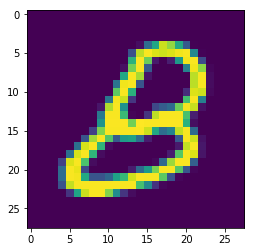

In [7]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [8]:
train_ratio = 0.9

In [9]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [10]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

In [11]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = -((Y+delta)*np.log(Y_hat+delta) + (1-Y+delta)*np.log(1-Y_hat+delta))
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(sigmoid)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(sigmoid_prime)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [12]:
def loss_function_for__config_multi_layer_classifier_with_dropout_regularization(Y_hat, Y):
    delta = 1e-10
    l = -((Y+delta)*np.log(Y_hat+delta) + (1-Y+delta)*np.log(1-Y_hat+delta))
    return l

def forward_propagation_for_config_multi_layer_classifier_with_dropout_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    keep_prob = model['keep_prob']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
        dropout = np.random.uniform(0.0, 1.0, A[i].shape)
        dropout = dropout < keep_prob[i]
        A[i] = A[i] * dropout
        A[i] = A[i] / keep_prob[i]
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_with_dropout_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_with_dropout_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_with_dropout_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_with_dropout_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    keep_prob = [1] + [0.8 for i in range(L-1)] + [1]
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(sigmoid)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(sigmoid_prime)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_with_dropout_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['keep_prob'] = keep_prob
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_with_dropout_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_with_dropout_regularization
    model['update'] = update_for_config_multi_layer_classifier_with_dropout_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_with_dropout_regularization
    
    return model

In [15]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [27]:
model = config_multi_layer_classifier_without_regularization(train_X, train_Y, [16, 16, 16, 16, 16, 16], 0.8)

iteration 0, current loss: 91544.496673
iteration 1, current loss: 91296.704484
iteration 2, current loss: 91020.932822
iteration 3, current loss: 90927.957583
iteration 4, current loss: 90729.650064
iteration 5, current loss: 90722.282231
iteration 6, current loss: 90556.873750
iteration 7, current loss: 90505.421145
iteration 8, current loss: 90403.065171
iteration 9, current loss: 90230.575289
iteration 10, current loss: 90010.241845
iteration 11, current loss: 89906.795778
iteration 12, current loss: 89636.080388
iteration 13, current loss: 89490.276575
iteration 14, current loss: 89320.723401
iteration 15, current loss: 89190.481045
iteration 16, current loss: 88934.252129
iteration 17, current loss: 88803.649181
iteration 18, current loss: 88765.730666
iteration 19, current loss: 88590.698533
iteration 20, current loss: 88674.496893
iteration 21, current loss: 88459.792393
iteration 22, current loss: 88487.413214
iteration 23, current loss: 88102.730481
iteration 24, current loss

iteration 198, current loss: 67504.542776
iteration 199, current loss: 67459.271671
iteration 200, current loss: 67436.816846
iteration 201, current loss: 67578.126630
iteration 202, current loss: 67270.989927
iteration 203, current loss: 67254.252171
iteration 204, current loss: 67065.760867
iteration 205, current loss: 67007.462162
iteration 206, current loss: 66894.520982
iteration 207, current loss: 66934.462982
iteration 208, current loss: 66713.570107
iteration 209, current loss: 66687.558798
iteration 210, current loss: 66582.184313
iteration 211, current loss: 66598.302103
iteration 212, current loss: 66396.270675
iteration 213, current loss: 66289.663287
iteration 214, current loss: 66277.057165
iteration 215, current loss: 66352.946381
iteration 216, current loss: 66114.559007
iteration 217, current loss: 66079.318033
iteration 218, current loss: 66075.514828
iteration 219, current loss: 66210.456770
iteration 220, current loss: 66012.964579
iteration 221, current loss: 66251

iteration 394, current loss: 56356.066583
iteration 395, current loss: 56460.789681
iteration 396, current loss: 56351.277225
iteration 397, current loss: 56566.799271
iteration 398, current loss: 56475.300603
iteration 399, current loss: 56749.853830
iteration 400, current loss: 56489.592448
iteration 401, current loss: 56597.292337
iteration 402, current loss: 56399.157180
iteration 403, current loss: 56244.891858
iteration 404, current loss: 56281.507447
iteration 405, current loss: 56106.954492
iteration 406, current loss: 56164.174086
iteration 407, current loss: 56294.915663
iteration 408, current loss: 56361.365719
iteration 409, current loss: 56462.596985
iteration 410, current loss: 56407.774297
iteration 411, current loss: 55908.802712
iteration 412, current loss: 55790.317320
iteration 413, current loss: 55671.489751
iteration 414, current loss: 56016.963448
iteration 415, current loss: 56067.000404
iteration 416, current loss: 56519.474306
iteration 417, current loss: 56490

iteration 590, current loss: 49573.471163
iteration 591, current loss: 49751.610370
iteration 592, current loss: 49515.357538
iteration 593, current loss: 49462.800068
iteration 594, current loss: 49419.268389
iteration 595, current loss: 49597.476862
iteration 596, current loss: 50211.559479
iteration 597, current loss: 50628.487432
iteration 598, current loss: 51264.261767
iteration 599, current loss: 51426.926177
iteration 600, current loss: 50602.034021
iteration 601, current loss: 50198.839786
iteration 602, current loss: 49609.657919
iteration 603, current loss: 49355.964079
iteration 604, current loss: 49286.925354
iteration 605, current loss: 49769.529112
iteration 606, current loss: 50123.260502
iteration 607, current loss: 50473.618769
iteration 608, current loss: 50450.957637
iteration 609, current loss: 50184.757908
iteration 610, current loss: 49543.572720
iteration 611, current loss: 49444.154841
iteration 612, current loss: 49587.812896
iteration 613, current loss: 49593

iteration 786, current loss: 45014.261423
iteration 787, current loss: 44573.622969
iteration 788, current loss: 44347.299301
iteration 789, current loss: 44299.639755
iteration 790, current loss: 44563.347528
iteration 791, current loss: 44719.506663
iteration 792, current loss: 45405.036235
iteration 793, current loss: 45789.086765
iteration 794, current loss: 45620.675021
iteration 795, current loss: 45482.050260
iteration 796, current loss: 45032.329321
iteration 797, current loss: 45144.962735
iteration 798, current loss: 45545.231518
iteration 799, current loss: 46121.681185
iteration 800, current loss: 46022.288092
iteration 801, current loss: 45133.291637
iteration 802, current loss: 44510.557457
iteration 803, current loss: 44340.676345
iteration 804, current loss: 44136.661501
iteration 805, current loss: 44420.734099
iteration 806, current loss: 44807.336222
iteration 807, current loss: 45024.488433
iteration 808, current loss: 45231.103795
iteration 809, current loss: 44573

iteration 982, current loss: 41659.708170
iteration 983, current loss: 41660.751486
iteration 984, current loss: 41106.697619
iteration 985, current loss: 41477.756675
iteration 986, current loss: 41387.325004
iteration 987, current loss: 42137.510235
iteration 988, current loss: 41412.978610
iteration 989, current loss: 41580.088438
iteration 990, current loss: 40903.448451
iteration 991, current loss: 41316.941407
iteration 992, current loss: 41438.542655
iteration 993, current loss: 42544.546731
iteration 994, current loss: 42659.078499
iteration 995, current loss: 42134.903563
iteration 996, current loss: 40897.013569
iteration 997, current loss: 40672.607628
iteration 998, current loss: 40427.238510
iteration 999, current loss: 40401.282521
iteration 1000, current loss: 40217.207801
iteration 1001, current loss: 40325.574740
iteration 1002, current loss: 40731.312102
iteration 1003, current loss: 41326.671801
iteration 1004, current loss: 41995.941903
iteration 1005, current loss:

iteration 1173, current loss: 39043.584164
iteration 1174, current loss: 38695.392494
iteration 1175, current loss: 38627.681671
iteration 1176, current loss: 38406.681078
iteration 1177, current loss: 38880.615665
iteration 1178, current loss: 39151.442518
iteration 1179, current loss: 39205.164460
iteration 1180, current loss: 39383.609463
iteration 1181, current loss: 39781.385185
iteration 1182, current loss: 39560.184666
iteration 1183, current loss: 39720.194885
iteration 1184, current loss: 38704.037051
iteration 1185, current loss: 38455.855070
iteration 1186, current loss: 38435.636140
iteration 1187, current loss: 38770.705581
iteration 1188, current loss: 38598.196166
iteration 1189, current loss: 39065.217796
iteration 1190, current loss: 38827.768370
iteration 1191, current loss: 38693.429007
iteration 1192, current loss: 38945.187727
iteration 1193, current loss: 39060.634724
iteration 1194, current loss: 39004.347873
iteration 1195, current loss: 38558.361979
iteration 1

iteration 1364, current loss: 36248.753310
iteration 1365, current loss: 36667.400177
iteration 1366, current loss: 37036.422403
iteration 1367, current loss: 37387.180804
iteration 1368, current loss: 37767.911399
iteration 1369, current loss: 37798.246899
iteration 1370, current loss: 38257.629055
iteration 1371, current loss: 37334.415726
iteration 1372, current loss: 37010.582778
iteration 1373, current loss: 36885.350457
iteration 1374, current loss: 37155.822863
iteration 1375, current loss: 36746.716043
iteration 1376, current loss: 36880.993285
iteration 1377, current loss: 36609.774815
iteration 1378, current loss: 36862.400790
iteration 1379, current loss: 36500.954096
iteration 1380, current loss: 36467.862015
iteration 1381, current loss: 35969.775303
iteration 1382, current loss: 35960.670037
iteration 1383, current loss: 35750.264765
iteration 1384, current loss: 35654.540905
iteration 1385, current loss: 35864.946381
iteration 1386, current loss: 36012.736716
iteration 1

iteration 1555, current loss: 35533.647852
iteration 1556, current loss: 35561.397471
iteration 1557, current loss: 35435.310902
iteration 1558, current loss: 35134.585518
iteration 1559, current loss: 35285.799274
iteration 1560, current loss: 34922.736495
iteration 1561, current loss: 34663.930811
iteration 1562, current loss: 34447.741596
iteration 1563, current loss: 34440.146799
iteration 1564, current loss: 34612.595506
iteration 1565, current loss: 34782.003139
iteration 1566, current loss: 35103.678282
iteration 1567, current loss: 35243.755725
iteration 1568, current loss: 35587.672434
iteration 1569, current loss: 36322.656957
iteration 1570, current loss: 36242.198285
iteration 1571, current loss: 37297.979780
iteration 1572, current loss: 37025.884956
iteration 1573, current loss: 37366.085194
iteration 1574, current loss: 35943.602360
iteration 1575, current loss: 36134.167191
iteration 1576, current loss: 34991.583341
iteration 1577, current loss: 35022.337420
iteration 1

iteration 1746, current loss: 35136.392248
iteration 1747, current loss: 34317.999822
iteration 1748, current loss: 33749.743367
iteration 1749, current loss: 33624.075602
iteration 1750, current loss: 34273.413940
iteration 1751, current loss: 34293.848007
iteration 1752, current loss: 34054.308405
iteration 1753, current loss: 34078.102700
iteration 1754, current loss: 34827.531276
iteration 1755, current loss: 34245.531355
iteration 1756, current loss: 34253.994663
iteration 1757, current loss: 33535.105363
iteration 1758, current loss: 33430.973483
iteration 1759, current loss: 33092.183555
iteration 1760, current loss: 32831.491011
iteration 1761, current loss: 32643.112245
iteration 1762, current loss: 32803.659082
iteration 1763, current loss: 32700.123606
iteration 1764, current loss: 33166.738336
iteration 1765, current loss: 33695.845158
iteration 1766, current loss: 33651.988330
iteration 1767, current loss: 34040.799152
iteration 1768, current loss: 34141.728597
iteration 1

iteration 1937, current loss: 33169.330048
iteration 1938, current loss: 33078.440579
iteration 1939, current loss: 32749.097368
iteration 1940, current loss: 32628.194972
iteration 1941, current loss: 32880.914332
iteration 1942, current loss: 33472.606912
iteration 1943, current loss: 33168.183325
iteration 1944, current loss: 34442.225327
iteration 1945, current loss: 33157.449767
iteration 1946, current loss: 33237.797931
iteration 1947, current loss: 32566.494364
iteration 1948, current loss: 32225.073024
iteration 1949, current loss: 31739.987921
iteration 1950, current loss: 31889.534809
iteration 1951, current loss: 32149.753920
iteration 1952, current loss: 32312.825012
iteration 1953, current loss: 32355.175895
iteration 1954, current loss: 32418.118736
iteration 1955, current loss: 32552.256773
iteration 1956, current loss: 32853.710273
iteration 1957, current loss: 33151.227337
iteration 1958, current loss: 33720.389024
iteration 1959, current loss: 33070.847943
iteration 1

iteration 2128, current loss: 32453.894798
iteration 2129, current loss: 31961.842362
iteration 2130, current loss: 31734.685668
iteration 2131, current loss: 31277.716036
iteration 2132, current loss: 31396.519868
iteration 2133, current loss: 30908.274029
iteration 2134, current loss: 30969.945974
iteration 2135, current loss: 30618.133633
iteration 2136, current loss: 30928.741639
iteration 2137, current loss: 30767.966910
iteration 2138, current loss: 31569.002576
iteration 2139, current loss: 32200.328226
iteration 2140, current loss: 32866.233003
iteration 2141, current loss: 32410.289095
iteration 2142, current loss: 32787.669063
iteration 2143, current loss: 32076.193132
iteration 2144, current loss: 32781.342894
iteration 2145, current loss: 31561.683080
iteration 2146, current loss: 31538.351127
iteration 2147, current loss: 31071.688466
iteration 2148, current loss: 31141.965021
iteration 2149, current loss: 30861.559147
iteration 2150, current loss: 30910.506693
iteration 2

iteration 2319, current loss: 30770.723908
iteration 2320, current loss: 30557.555883
iteration 2321, current loss: 30573.869557
iteration 2322, current loss: 30870.319999
iteration 2323, current loss: 30564.173341
iteration 2324, current loss: 30912.876401
iteration 2325, current loss: 31578.217002
iteration 2326, current loss: 32108.849927
iteration 2327, current loss: 32776.929933
iteration 2328, current loss: 32048.817430
iteration 2329, current loss: 30881.014031
iteration 2330, current loss: 30762.935638
iteration 2331, current loss: 31019.779551
iteration 2332, current loss: 30902.905354
iteration 2333, current loss: 31636.507853
iteration 2334, current loss: 30894.490178
iteration 2335, current loss: 30762.801961
iteration 2336, current loss: 30699.160099
iteration 2337, current loss: 30737.545800
iteration 2338, current loss: 31227.944901
iteration 2339, current loss: 31041.685111
iteration 2340, current loss: 30945.662860
iteration 2341, current loss: 31154.253012
iteration 2

iteration 2510, current loss: 31295.791221
iteration 2511, current loss: 30610.458208
iteration 2512, current loss: 29883.374835
iteration 2513, current loss: 29812.333074
iteration 2514, current loss: 30126.031773
iteration 2515, current loss: 29647.410986
iteration 2516, current loss: 29661.360221
iteration 2517, current loss: 29997.822276
iteration 2518, current loss: 30618.893794
iteration 2519, current loss: 30407.398661
iteration 2520, current loss: 30202.691233
iteration 2521, current loss: 30586.637794
iteration 2522, current loss: 31140.955721
iteration 2523, current loss: 31074.585540
iteration 2524, current loss: 31143.283854
iteration 2525, current loss: 29726.005697
iteration 2526, current loss: 29143.451407
iteration 2527, current loss: 29192.393934
iteration 2528, current loss: 29361.377740
iteration 2529, current loss: 29496.392641
iteration 2530, current loss: 29794.955212
iteration 2531, current loss: 30621.114312
iteration 2532, current loss: 30389.676412
iteration 2

iteration 2701, current loss: 29633.256483
iteration 2702, current loss: 30633.676297
iteration 2703, current loss: 30215.892195
iteration 2704, current loss: 30666.107894
iteration 2705, current loss: 30840.083389
iteration 2706, current loss: 30445.212736
iteration 2707, current loss: 29580.825164
iteration 2708, current loss: 29818.126033
iteration 2709, current loss: 29915.585512
iteration 2710, current loss: 29039.610811
iteration 2711, current loss: 28841.090856
iteration 2712, current loss: 28625.485799
iteration 2713, current loss: 28285.347769
iteration 2714, current loss: 28519.680105
iteration 2715, current loss: 28325.612588
iteration 2716, current loss: 28831.532388
iteration 2717, current loss: 29009.026607
iteration 2718, current loss: 29766.343455
iteration 2719, current loss: 29085.483353
iteration 2720, current loss: 29513.150058
iteration 2721, current loss: 29735.607247
iteration 2722, current loss: 30310.639903
iteration 2723, current loss: 30785.018839
iteration 2

iteration 2892, current loss: 30420.318376
iteration 2893, current loss: 30788.433221
iteration 2894, current loss: 29709.663230
iteration 2895, current loss: 29862.251984
iteration 2896, current loss: 29363.114262
iteration 2897, current loss: 28956.513912
iteration 2898, current loss: 28673.897430
iteration 2899, current loss: 28433.610736
iteration 2900, current loss: 28934.919564
iteration 2901, current loss: 28773.924469
iteration 2902, current loss: 29228.132994
iteration 2903, current loss: 29009.868773
iteration 2904, current loss: 28728.139517
iteration 2905, current loss: 29154.157127
iteration 2906, current loss: 29731.593055
iteration 2907, current loss: 29444.910555
iteration 2908, current loss: 28910.109570
iteration 2909, current loss: 28642.019534
iteration 2910, current loss: 28507.123606
iteration 2911, current loss: 29023.555871
iteration 2912, current loss: 28673.095800
iteration 2913, current loss: 29124.366547
iteration 2914, current loss: 28611.092239
iteration 2

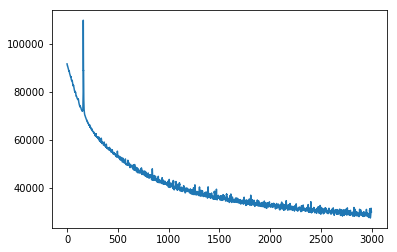

In [30]:
train_model(3000, model)
costs = model['costs']
plt.plot(costs[-3000:])
#print(W[1])

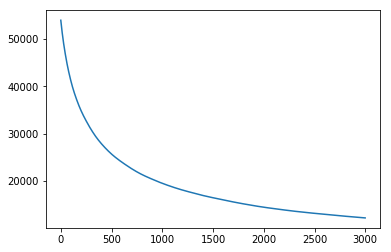

In [73]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [18]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [31]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.884841
test set accuracy: 0.842381


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [79]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [80]:
test_Y = predict(test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [81]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [82]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

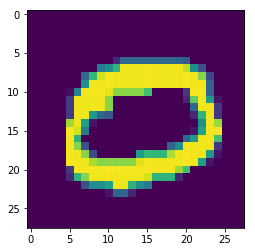

In [83]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])